# Introduction
In today's world, energy plays a key role in the development of the country, its economy and especially in the comfort of society. The rapid growth in electricity consumption requires accurate prediction of the distribution of electricity consumption. This leads to the fact that as the demand for energy rises the importance of energy optimization and resource planning increases. In general, the demand for energy depends on various factors such as weather, population, types of equipment and availability of industrial facilities. It is also important to forecast the energy consumption of individual large industrial enterprises, which either have their own power generation plants or are fed by a centralized power plant, are the largest consumers of electricity. Taking a global approach to the issue, we can say that forecasting allows the centralized power system to deliver electricity in a more optimal way. In addition, power consumption forecasting plays a significant role in supporting the efficiency of power systems, including also extending the service life of power system elements indirectly when used in a heavy-duty mode. The dependence on a large number of factors significantly complicates methods for predicting energy consumption. Complex intelligent systems based on advanced solutions in the field of mathematics and computer science, developed in the last century and only now getting enough conditions for practical application, can help to solve the issues of complex analysis of optimal energy distribution. The named aspects make this research topic particularly relevant.


Modern data analytics, including machine learning and neural networks, provide unprecedented opportunities for energy forecasting tasks. While there is an abundance of opportunities for intelligent analysis of complex and voluminous data, each architecture has its own characteristics that are suited to a particular type of task. In the case of energy forecasting, a particular type of data structure - time series - has to be analyzed. Of special interest are recurrent neural networks (RNN) and their advanced versions such as LSTM (Long Short-Term Memory). These methods have proven their effectiveness in working with time series, which makes them suitable tools for solving forecasting problems in the energy sector.


The goal of this work is to develop an intelligent system for analyzing and forecasting energy consumption based on neural networks. To achieve this goal, the following objectives were set:
1.	To study the theoretical background of neural networks, in particular recurrent models and LSTM.
2.	To conduct exploratory data analysis.
3.	Prepare data for modeling with LSTM requirements in mind.
4.	Develop and train an LSTM neural model for forecasting energy consumption.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


## Dataset Overview
This dataset contains a real-world electricity demand dataset that is scrapped from the open-source data portal OpenEI. The dataset has been modified to have one-year records of hourly electricity consumption of a hospital building located in Phoenix, USA. The readings are taken in a year from January 1st to December 31st, starting from 00:00 to 23:00 each day which sums up to a total of 8760 data instances. The data is arranged in a time series manner whereby the power con-sumption in kilowatt hour (kWh) had been measured in an hour resolution.

In [ ]:
# Data loading (Hospital Building Dataset)
# Dataset: https://github.com/Shahid-Fakhri/Electricity-Consumption
file_path = '/content/drive/MyDrive/Hospital Building Dataset.xlsx'
data = pd.read_excel(file_path)

In [ ]:
# Data overview
data.head()

,Date/Time,Electricity:Facility [kW](Hourly),Fans:Electricity [kW](Hourly),Cooling:Electricity [kW](Hourly),Heating:Electricity [kW](Hourly),InteriorLights:Electricity [kW](Hourly),InteriorEquipment:Electricity [kW](Hourly),Gas:Facility [kW](Hourly),Heating:Gas [kW](Hourly),InteriorEquipment:Gas [kW](Hourly),Water Heater:WaterSystems:Gas [kW](Hourly)
0,01/01 01:00:00,914.272082,101.24704,520.281440,0,34.961655,113.31278,557.289660,542.921283,5.66467,8.703708
1,01/01 02:00:00,831.588770,101.24704,452.930818,0,34.961655,113.31278,572.689167,558.319891,5.66467,8.704606
2,01/01 03:00:00,847.924133,101.24704,469.464822,0,34.961655,113.31278,593.760011,570.706199,5.66467,17.389142
3,01/01 04:00:00,859.587303,101.24704,478.672232,0,34.961655,113.31278,595.800299,581.431160,5.66467,8.704469
4,01/01 05:00:00,865.348935,101.24704,474.793737,0,44.493766,113.31278,604.834239,581.780751,5.66467,17.388817


# EDA

In [ ]:
data.rename(columns={
    'Date/Time': 'datetime',
    'Electricity:Facility [kW](Hourly)': 'consumption'
}, inplace=True)

In [ ]:
# Converting date and time
data['datetime'] = pd.to_datetime(data['datetime'], format='%m/%d %H:%M:%S', errors='coerce')

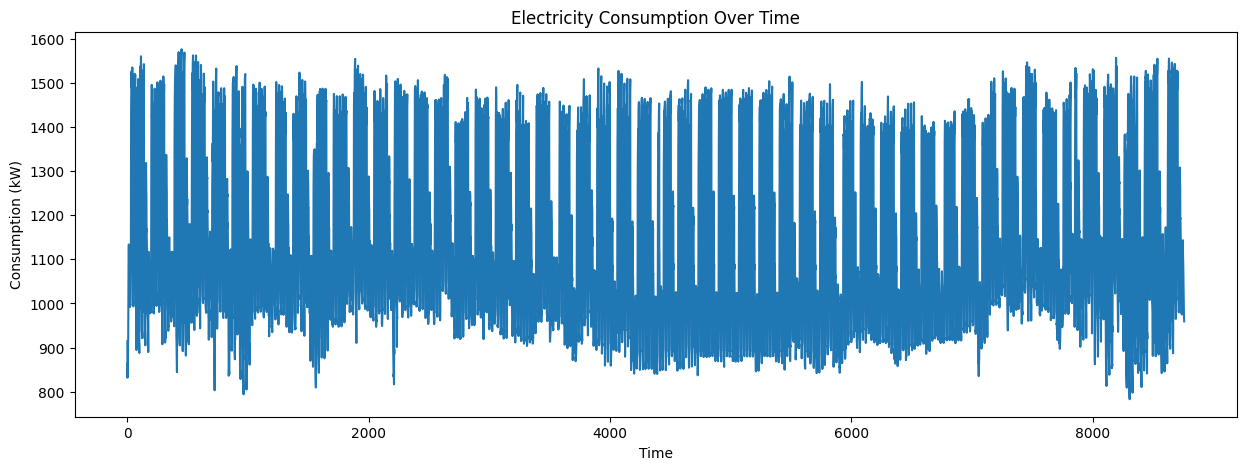

In [ ]:
# Visualization of raw data
plt.figure(figsize=(15, 5))
data['consumption'].plot(title='Electricity Consumption Over Time')
plt.xlabel('Time')
plt.ylabel('Consumption (kW)')
plt.show()

In [ ]:
# Set indecies
data.set_index('datetime', inplace=True, drop=False)

In [ ]:
# Filling gaps
if data.isnull().sum().any():
    print("Gaps filled")
    data['consumption'].fillna(method='ffill', inplace=True)

Gaps filled


<ipython-input-8-703b3bd26905>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['consumption'].fillna(method='ffill', inplace=True)
<ipython-input-8-703b3bd26905>:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['consumption'].fillna(method='ffill', inplace=True)


In [ ]:
# Data normalization
scaler = MinMaxScaler()
data['consumption_scaled'] = scaler.fit_transform(data[['consumption']])

In [ ]:
# Creating time windows for LSTM
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        label = data[i + seq_length]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

In [ ]:
seq_len = 24  # Using the last 24 hours for the forecast
data_values = data['consumption_scaled'].values
X, y = create_sequences(data_values, seq_len)

In [ ]:
# Separation of data into training and test samples
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [ ]:
# Shape change for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [ ]:
# LSTM model building
model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(seq_len, 1)),
    LSTM(50, activation='relu'),
    Dense(1)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Model compilation
from tensorflow.keras.optimizers.schedules import ExponentialDecay

lr_schedule = ExponentialDecay(
    initial_learning_rate=0.001, # standard learning rate value for the Adam optimizer
    decay_steps=10000, # after how many steps (iterations of training) the learning rate will be reduced
    decay_rate=0.9 # coefficient of learning rate reduction
)

optimizer = Adam(learning_rate=lr_schedule)

#optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_absolute_error'])

In [ ]:
# Training a model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=2)

Epoch 1/20
219/219 - 10s - 46ms/step - loss: 0.0534 - mean_absolute_error: 0.1789 - val_loss: 0.0184 - val_mean_absolute_error: 0.1087
Epoch 2/20
219/219 - 8s - 38ms/step - loss: 0.0118 - mean_absolute_error: 0.0812 - val_loss: 0.0075 - val_mean_absolute_error: 0.0649
Epoch 3/20
219/219 - 5s - 22ms/step - loss: 0.0074 - mean_absolute_error: 0.0621 - val_loss: 0.0059 - val_mean_absolute_error: 0.0545
Epoch 4/20
219/219 - 5s - 24ms/step - loss: 0.0056 - mean_absolute_error: 0.0537 - val_loss: 0.0055 - val_mean_absolute_error: 0.0563
Epoch 5/20
219/219 - 10s - 46ms/step - loss: 0.0051 - mean_absolute_error: 0.0515 - val_loss: 0.0066 - val_mean_absolute_error: 0.0668
Epoch 6/20
219/219 - 9s - 42ms/step - loss: 0.0045 - mean_absolute_error: 0.0484 - val_loss: 0.0054 - val_mean_absolute_error: 0.0552
Epoch 7/20
219/219 - 5s - 25ms/step - loss: 0.0043 - mean_absolute_error: 0.0469 - val_loss: 0.0037 - val_mean_absolute_error: 0.0436
Epoch 8/20
219/219 - 9s - 41ms/step - loss: 0.0036 - mean_ab

In [ ]:
# Estimating the model
loss, mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss}")
print(f"Test MAE: {mae}")

Test Loss: 0.002400325145572424
Test MAE: 0.034918412566185


In [ ]:
# Model estimation
predictions = model.predict(X_test)
predictions_rescaled = scaler.inverse_transform(predictions)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


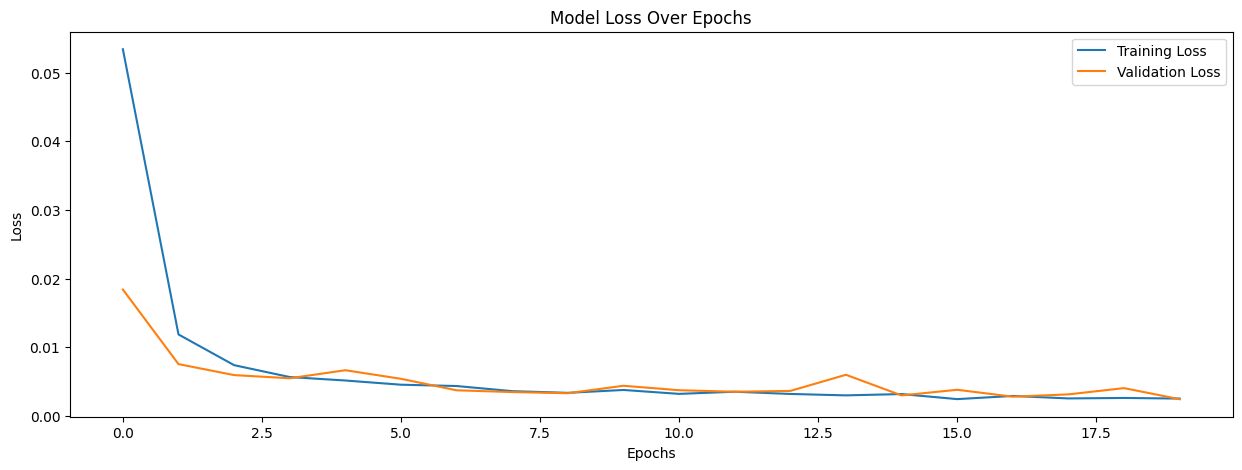

In [ ]:
# Plotting a graph of the training
plt.figure(figsize=(15, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

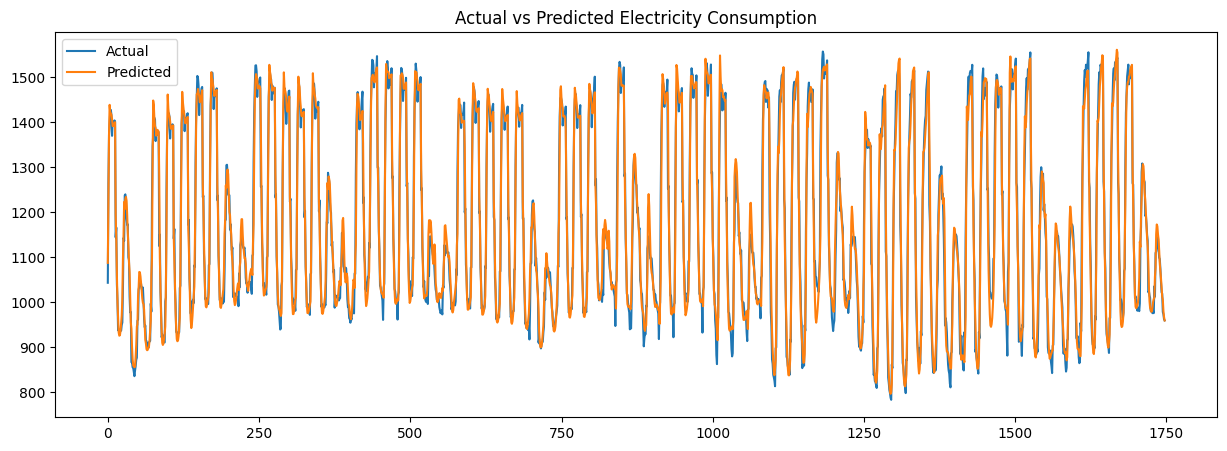

In [ ]:
# Visualization of the results
plt.figure(figsize=(15, 5))
plt.plot(y_test_rescaled, label='Actual')
plt.plot(predictions_rescaled, label='Predicted')
plt.legend()
plt.title('Actual vs Predicted Electricity Consumption')
plt.show()

In [ ]:
print(data['consumption'].describe())

count    8760.000000
mean     1156.322459
std       214.808740
min       782.796552
25%       975.316202
50%      1093.827089
75%      1396.244148
max      1576.234017
Name: consumption, dtype: float64


In [ ]:
rmse = np.sqrt(mean_squared_error(y_test_rescaled, predictions_rescaled))
mae = mean_absolute_error(y_test_rescaled, predictions_rescaled)
mape = np.mean(np.abs((y_test_rescaled - predictions_rescaled) / y_test_rescaled)) * 100

print(f"Mean Absolute Percentage Error (MAPE): {mape}%")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")

Mean Absolute Percentage Error (MAPE): 2.4383676144488056%
Root Mean Squared Error (RMSE): 38.87297542503131
Mean Absolute Error (MAE): 27.7055742688684


# Results
MAPE is less than 10-15%, the model is considered accurate enough for practical purposes.
The value of RMSE = 38.87 indicates the average model prediction error in kilowatt-hours (kWh). This is a good indicator of the model's predictive performance, since the average energy consumption = 1156.32 kWh. Thus, the model is wrong by about 3.3% compared to the average consumption.


# Conclusion
The result obtained suggests that the created recurrent neural network model satisfies the performance measures for a given task of forecasting energy consumption in this research object.